## Learning average SR

In [1]:
from deep_rl import *
import matplotlib.pyplot as plt
import torch
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

/network/home/penmetss/DeepRL/deeprl/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/network/home/penmetss/DeepRL/deeprl/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/network/home/penmetss/DeepRL/deeprl/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/network/home/penmetss/DeepRL/deeprl/lib

In [2]:
config.state_dim = 104
config.action_dim = 4
net1 = SRNet(config.action_dim, SRIdentityBody(config.state_dim), \
                        Phi2Psi(config.state_dim, config.action_dim, hidden_units=(104,)))

In [9]:
for parameter in net1.parameters():
    print(parameter.size())

torch.Size([104])
torch.Size([104, 104])
torch.Size([104])
torch.Size([416, 104])
torch.Size([416])


In [6]:

net = SRNet(config.action_dim, SRIdentityBody(config.state_dim))

In [10]:
for parameter in net.parameters():
    print(parameter.size())

torch.Size([104])
torch.Size([104, 104])
torch.Size([104])
torch.Size([416, 104])
torch.Size([416])


In [8]:
net1.parameters

<bound method Module.parameters of SRNet(
  (body): SRIdentityBody()
  (phi2psi): Phi2Psi(
    (layers): ModuleList(
      (0): Linear(in_features=104, out_features=104, bias=True)
    )
    (final): Linear(in_features=104, out_features=416, bias=True)
  )
)>

In [9]:
a, b, c = net(torch.rand(10,104))
print(a.size(), b.size(), c.size())

torch.Size([10, 104]) torch.Size([10, 4, 104]) torch.Size([10, 4])


In [5]:
class SRNet(nn.Module):
    """
    Added by Surya.
    SR fully connected body network.
    """
    def __init__(self, output_dim, body, gate=F.relu):
        super(SRNet, self).__init__()
        self.body = body
        self.output_dim = output_dim# TODO: check if this is the right way to do it
        self.layer1 = layer_init(nn.Linear(body.feature_dim, body.feature_dim))
        self.layer2 = layer_init(nn.Linear(body.feature_dim, body.feature_dim * output_dim))
        self.gate = gate
        self.feature_dim = body.feature_dim * output_dim
        self.w = Parameter(torch.Tensor(body.feature_dim))

    def forward(self, x):
        phi = self.body(tensor(x)) # shape: b x state_dim
        psi = self.gate(self.layer1(phi)) # shape: b x state_dim
        psi = self.gate(self.layer2(psi)) # shape: b x (state_dim*action_dim)
        psi = psi.view(psi.size(0), self.output_dim, self.body.feature_dim) # shape: b x action_dim x state_dim
        out = torch.matmul(psi, self.w)

        return phi, psi, out

In [2]:
def dsr_feature(**kwargs):
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()
    config.c = 0.1

    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, 0.001)
#     config.network_fn = lambda: SRNet(config.action_dim, SRIdentityBody(config.state_dim))
    config.network_fn = lambda: SRNet(config.action_dim, SRIdentityBody(config.state_dim), \
                        Phi2Psi(config.state_dim, config.action_dim, hidden_units=(104,)))
    # config.network_fn = lambda: DuelingNet(config.action_dim, FCBody(config.state_dim))
    # config.replay_fn = lambda: Replay(memory_size=int(1e4), batch_size=10)
    config.replay_fn = lambda: AsyncReplay(memory_size=int(1e4), batch_size=10)

    config.random_action_prob = LinearSchedule(1.0, 0.1, 1e4)
    config.discount = 0.99
    config.target_network_update_freq = 200
    config.exploration_steps = 1000
    # config.double_q = True
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.eval_interval = int(5e3)
    config.max_steps = 3e4
    config.async_actor = False
    run_steps(DSRAgent(config))
    
# DQN
def dqn_feature(**kwargs):
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()

    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, 0.001)
    config.network_fn = lambda: VanillaNet(config.action_dim, FCBody(config.state_dim))
    # config.network_fn = lambda: DuelingNet(config.action_dim, FCBody(config.state_dim))
    # config.replay_fn = lambda: Replay(memory_size=int(1e4), batch_size=10)
    config.replay_fn = lambda: AsyncReplay(memory_size=int(1e4), batch_size=10)

    config.random_action_prob = LinearSchedule(1.0, 0.1, 1e4)
    config.discount = 0.99
    config.target_network_update_freq = 200
    config.exploration_steps = 1000
    # config.double_q = True
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.eval_interval = int(5e3)
    config.max_steps = 1e5
    config.async_actor = False
    run_steps(DQNAgent(config))

In [3]:
mkdir('log')
mkdir('tf_log')
set_one_thread()
random_seed()
select_device(-1)

In [4]:
game = 'FourRooms'
dsr_feature(game=game)

2020-03-02 16:22:26,699 - root - INFO: steps 0, 279620266.67 steps/s
2020-03-02 16:22:27,110 - root - INFO: steps 0, episodic_return_test -180.20(18.78)
2020-03-02 16:22:27,201 - root - INFO: steps 3, episodic_return_train -3
2020-03-02 16:22:27,264 - root - INFO: steps 203, episodic_return_train -200
2020-03-02 16:22:27,285 - root - INFO: steps 262, episodic_return_train -58
2020-03-02 16:22:27,348 - root - INFO: steps 462, episodic_return_train -200
2020-03-02 16:22:27,411 - root - INFO: steps 662, episodic_return_train -200
2020-03-02 16:22:27,465 - root - INFO: steps 780, episodic_return_train -117
2020-03-02 16:22:27,509 - root - INFO: steps 909, episodic_return_train -128
2020-03-02 16:22:27,538 - root - INFO: steps 1000, 1195.31 steps/s
2020-03-02 16:22:27,597 - root - INFO: steps 1032, episodic_return_train -122
2020-03-02 16:22:27,883 - root - INFO: steps 1232, episodic_return_train -200
2020-03-02 16:22:27,975 - root - INFO: steps 1307, episodic_return_train -74
2020-03-02 16

2020-03-02 16:22:40,361 - root - INFO: steps 11145, episodic_return_train -11
2020-03-02 16:22:40,464 - root - INFO: steps 11251, episodic_return_train -105
2020-03-02 16:22:40,488 - root - INFO: steps 11265, episodic_return_train -13
2020-03-02 16:22:40,729 - root - INFO: steps 11465, episodic_return_train -200
2020-03-02 16:22:40,986 - root - INFO: steps 11665, episodic_return_train -200
2020-03-02 16:22:41,204 - root - INFO: steps 11865, episodic_return_train -200
2020-03-02 16:22:41,336 - root - INFO: steps 12000, 895.95 steps/s
2020-03-02 16:22:41,408 - root - INFO: steps 12065, episodic_return_train -200
2020-03-02 16:22:41,423 - root - INFO: steps 12076, episodic_return_train -10
2020-03-02 16:22:41,433 - root - INFO: steps 12086, episodic_return_train -9
2020-03-02 16:22:41,440 - root - INFO: steps 12090, episodic_return_train -3
2020-03-02 16:22:41,651 - root - INFO: steps 12290, episodic_return_train -200
2020-03-02 16:22:41,668 - root - INFO: steps 12306, episodic_return_tra

2020-03-02 16:22:47,871 - root - INFO: steps 16909, episodic_return_train -22
2020-03-02 16:22:47,894 - root - INFO: steps 16925, episodic_return_train -15
2020-03-02 16:22:47,910 - root - INFO: steps 16936, episodic_return_train -10
2020-03-02 16:22:47,928 - root - INFO: steps 16948, episodic_return_train -11
2020-03-02 16:22:47,930 - root - INFO: steps 16949, episodic_return_train 0
2020-03-02 16:22:47,953 - root - INFO: steps 16964, episodic_return_train -14
2020-03-02 16:22:47,965 - root - INFO: steps 16973, episodic_return_train -8
2020-03-02 16:22:47,979 - root - INFO: steps 16980, episodic_return_train -6
2020-03-02 16:22:48,005 - root - INFO: steps 17000, 741.24 steps/s
2020-03-02 16:22:48,125 - root - INFO: steps 17092, episodic_return_train -111
2020-03-02 16:22:48,133 - root - INFO: steps 17099, episodic_return_train -6
2020-03-02 16:22:48,171 - root - INFO: steps 17127, episodic_return_train -27
2020-03-02 16:22:48,198 - root - INFO: steps 17145, episodic_return_train -17
2

2020-03-02 16:22:52,049 - root - INFO: steps 20000, 782.63 steps/s
2020-03-02 16:22:52,235 - root - INFO: steps 20000, episodic_return_test -66.70(27.63)
2020-03-02 16:22:52,244 - root - INFO: steps 20004, episodic_return_train -20
2020-03-02 16:22:52,277 - root - INFO: steps 20029, episodic_return_train -24
2020-03-02 16:22:52,284 - root - INFO: steps 20032, episodic_return_train -2
2020-03-02 16:22:52,301 - root - INFO: steps 20044, episodic_return_train -11
2020-03-02 16:22:52,328 - root - INFO: steps 20064, episodic_return_train -19
2020-03-02 16:22:52,329 - root - INFO: steps 20067, episodic_return_train -2
2020-03-02 16:22:52,345 - root - INFO: steps 20073, episodic_return_train -5
2020-03-02 16:22:52,361 - root - INFO: steps 20087, episodic_return_train -13
2020-03-02 16:22:52,446 - root - INFO: steps 20152, episodic_return_train -64
2020-03-02 16:22:52,644 - root - INFO: steps 20314, episodic_return_train -161
2020-03-02 16:22:52,661 - root - INFO: steps 20324, episodic_return_

2020-03-02 16:22:54,907 - root - INFO: steps 21921, episodic_return_train -8
2020-03-02 16:22:54,917 - root - INFO: steps 21929, episodic_return_train -7
2020-03-02 16:22:54,957 - root - INFO: steps 21966, episodic_return_train -36
2020-03-02 16:22:54,964 - root - INFO: steps 21970, episodic_return_train -3
2020-03-02 16:22:54,983 - root - INFO: steps 21986, episodic_return_train -15
2020-03-02 16:22:54,998 - root - INFO: steps 21999, episodic_return_train -12
2020-03-02 16:22:55,004 - root - INFO: steps 22000, 762.16 steps/s
2020-03-02 16:22:55,024 - root - INFO: steps 22017, episodic_return_train -17
2020-03-02 16:22:55,035 - root - INFO: steps 22027, episodic_return_train -9
2020-03-02 16:22:55,045 - root - INFO: steps 22033, episodic_return_train -5
2020-03-02 16:22:55,057 - root - INFO: steps 22038, episodic_return_train -4
2020-03-02 16:22:55,075 - root - INFO: steps 22049, episodic_return_train -10
2020-03-02 16:22:55,096 - root - INFO: steps 22061, episodic_return_train -11
202

2020-03-02 16:22:57,879 - root - INFO: steps 24244, episodic_return_train -29
2020-03-02 16:22:57,943 - root - INFO: steps 24284, episodic_return_train -39
2020-03-02 16:22:57,973 - root - INFO: steps 24301, episodic_return_train -16
2020-03-02 16:22:58,009 - root - INFO: steps 24323, episodic_return_train -21
2020-03-02 16:22:58,031 - root - INFO: steps 24335, episodic_return_train -11
2020-03-02 16:22:58,046 - root - INFO: steps 24343, episodic_return_train -7
2020-03-02 16:22:58,145 - root - INFO: steps 24403, episodic_return_train -59
2020-03-02 16:22:58,209 - root - INFO: steps 24443, episodic_return_train -39
2020-03-02 16:22:58,218 - root - INFO: steps 24445, episodic_return_train -1
2020-03-02 16:22:58,233 - root - INFO: steps 24452, episodic_return_train -6
2020-03-02 16:22:58,260 - root - INFO: steps 24468, episodic_return_train -15
2020-03-02 16:22:58,306 - root - INFO: steps 24497, episodic_return_train -28
2020-03-02 16:22:58,320 - root - INFO: steps 24505, episodic_return

2020-03-02 16:23:00,804 - root - INFO: steps 26154, episodic_return_train -19
2020-03-02 16:23:00,839 - root - INFO: steps 26176, episodic_return_train -21
2020-03-02 16:23:00,852 - root - INFO: steps 26185, episodic_return_train -8
2020-03-02 16:23:00,867 - root - INFO: steps 26193, episodic_return_train -7
2020-03-02 16:23:00,897 - root - INFO: steps 26213, episodic_return_train -19
2020-03-02 16:23:00,904 - root - INFO: steps 26216, episodic_return_train -2
2020-03-02 16:23:00,926 - root - INFO: steps 26233, episodic_return_train -16
2020-03-02 16:23:00,948 - root - INFO: steps 26250, episodic_return_train -16
2020-03-02 16:23:00,955 - root - INFO: steps 26252, episodic_return_train -1
2020-03-02 16:23:00,962 - root - INFO: steps 26256, episodic_return_train -3
2020-03-02 16:23:01,000 - root - INFO: steps 26285, episodic_return_train -28
2020-03-02 16:23:01,038 - root - INFO: steps 26314, episodic_return_train -28
2020-03-02 16:23:01,064 - root - INFO: steps 26328, episodic_return_t

2020-03-02 16:23:03,194 - root - INFO: steps 27788, episodic_return_train -8
2020-03-02 16:23:03,196 - root - INFO: steps 27791, episodic_return_train -2
2020-03-02 16:23:03,207 - root - INFO: steps 27799, episodic_return_train -7
2020-03-02 16:23:03,245 - root - INFO: steps 27828, episodic_return_train -28
2020-03-02 16:23:03,300 - root - INFO: steps 27877, episodic_return_train -48
2020-03-02 16:23:03,327 - root - INFO: steps 27901, episodic_return_train -23
2020-03-02 16:23:03,355 - root - INFO: steps 27925, episodic_return_train -23
2020-03-02 16:23:03,382 - root - INFO: steps 27948, episodic_return_train -22
2020-03-02 16:23:03,400 - root - INFO: steps 27967, episodic_return_train -18
2020-03-02 16:23:03,415 - root - INFO: steps 27979, episodic_return_train -11
2020-03-02 16:23:03,430 - root - INFO: steps 27988, episodic_return_train -8
2020-03-02 16:23:03,431 - root - INFO: steps 27990, episodic_return_train -1
2020-03-02 16:23:03,446 - root - INFO: steps 28000, 705.26 steps/s
20

2020-03-02 16:23:05,460 - root - INFO: steps 29461, episodic_return_train -15
2020-03-02 16:23:05,478 - root - INFO: steps 29474, episodic_return_train -12
2020-03-02 16:23:05,505 - root - INFO: steps 29491, episodic_return_train -16
2020-03-02 16:23:05,538 - root - INFO: steps 29513, episodic_return_train -21
2020-03-02 16:23:05,586 - root - INFO: steps 29551, episodic_return_train -37
2020-03-02 16:23:05,604 - root - INFO: steps 29561, episodic_return_train -9
2020-03-02 16:23:05,645 - root - INFO: steps 29599, episodic_return_train -37
2020-03-02 16:23:05,672 - root - INFO: steps 29613, episodic_return_train -13
2020-03-02 16:23:05,816 - root - INFO: steps 29718, episodic_return_train -104
2020-03-02 16:23:05,856 - root - INFO: steps 29744, episodic_return_train -25
2020-03-02 16:23:05,881 - root - INFO: steps 29762, episodic_return_train -17
2020-03-02 16:23:05,914 - root - INFO: steps 29787, episodic_return_train -24
2020-03-02 16:23:05,928 - root - INFO: steps 29792, episodic_ret

In [24]:
game = 'FourRooms'
dqn_feature(game=game)

2020-03-01 16:33:58,531 - root - INFO: steps 0, 91180521.74 steps/s
2020-03-01 16:33:58,861 - root - INFO: steps 0, episodic_return_test -200.00(0.00)
2020-03-01 16:33:58,929 - root - INFO: steps 199, episodic_return_train -200
2020-03-01 16:33:58,979 - root - INFO: steps 399, episodic_return_train -200
2020-03-01 16:33:59,030 - root - INFO: steps 599, episodic_return_train -200
2020-03-01 16:33:59,090 - root - INFO: steps 799, episodic_return_train -200
2020-03-01 16:33:59,144 - root - INFO: steps 999, episodic_return_train -200
2020-03-01 16:33:59,146 - root - INFO: steps 1000, 1639.31 steps/s
2020-03-01 16:33:59,217 - root - INFO: steps 1068, episodic_return_train -68
2020-03-01 16:33:59,250 - root - INFO: steps 1104, episodic_return_train -35
2020-03-01 16:33:59,360 - root - INFO: steps 1233, episodic_return_train -128
2020-03-01 16:33:59,514 - root - INFO: steps 1433, episodic_return_train -200
2020-03-01 16:33:59,678 - root - INFO: steps 1633, episodic_return_train -200
2020-03-0

2020-03-01 16:34:07,326 - root - INFO: steps 10390, episodic_return_train 0
2020-03-01 16:34:07,334 - root - INFO: steps 10396, episodic_return_train -5
2020-03-01 16:34:07,338 - root - INFO: steps 10400, episodic_return_train -3
2020-03-01 16:34:07,496 - root - INFO: steps 10600, episodic_return_train -200
2020-03-01 16:34:07,646 - root - INFO: steps 10800, episodic_return_train -200
2020-03-01 16:34:07,665 - root - INFO: steps 10823, episodic_return_train -22
2020-03-01 16:34:07,676 - root - INFO: steps 10828, episodic_return_train -4
2020-03-01 16:34:07,698 - root - INFO: steps 10855, episodic_return_train -26
2020-03-01 16:34:07,802 - root - INFO: steps 11000, 965.24 steps/s
2020-03-01 16:34:07,840 - root - INFO: steps 11055, episodic_return_train -200
2020-03-01 16:34:07,938 - root - INFO: steps 11194, episodic_return_train -138
2020-03-01 16:34:08,079 - root - INFO: steps 11363, episodic_return_train -168
2020-03-01 16:34:08,149 - root - INFO: steps 11445, episodic_return_train -

2020-03-01 16:34:12,239 - root - INFO: steps 16106, episodic_return_train -18
2020-03-01 16:34:12,391 - root - INFO: steps 16306, episodic_return_train -200
2020-03-01 16:34:12,447 - root - INFO: steps 16379, episodic_return_train -72
2020-03-01 16:34:12,460 - root - INFO: steps 16393, episodic_return_train -13
2020-03-01 16:34:12,470 - root - INFO: steps 16404, episodic_return_train -10
2020-03-01 16:34:12,477 - root - INFO: steps 16412, episodic_return_train -7
2020-03-01 16:34:12,558 - root - INFO: steps 16511, episodic_return_train -98
2020-03-01 16:34:12,566 - root - INFO: steps 16518, episodic_return_train -6
2020-03-01 16:34:12,635 - root - INFO: steps 16607, episodic_return_train -88
2020-03-01 16:34:12,656 - root - INFO: steps 16628, episodic_return_train -20
2020-03-01 16:34:12,743 - root - INFO: steps 16739, episodic_return_train -110
2020-03-01 16:34:12,751 - root - INFO: steps 16747, episodic_return_train -7
2020-03-01 16:34:12,827 - root - INFO: steps 16842, episodic_retu

2020-03-01 16:34:14,888 - root - INFO: steps 19288, episodic_return_train -21
2020-03-01 16:34:14,914 - root - INFO: steps 19320, episodic_return_train -31
2020-03-01 16:34:14,932 - root - INFO: steps 19340, episodic_return_train -19
2020-03-01 16:34:15,007 - root - INFO: steps 19439, episodic_return_train -98
2020-03-01 16:34:15,015 - root - INFO: steps 19445, episodic_return_train -5
2020-03-01 16:34:15,020 - root - INFO: steps 19448, episodic_return_train -2
2020-03-01 16:34:15,051 - root - INFO: steps 19485, episodic_return_train -36
2020-03-01 16:34:15,059 - root - INFO: steps 19493, episodic_return_train -7
2020-03-01 16:34:15,067 - root - INFO: steps 19500, episodic_return_train -6
2020-03-01 16:34:15,090 - root - INFO: steps 19530, episodic_return_train -29
2020-03-01 16:34:15,114 - root - INFO: steps 19556, episodic_return_train -25
2020-03-01 16:34:15,124 - root - INFO: steps 19567, episodic_return_train -10
2020-03-01 16:34:15,149 - root - INFO: steps 19585, episodic_return_

2020-03-01 16:34:16,415 - root - INFO: steps 20895, episodic_return_train -9
2020-03-01 16:34:16,458 - root - INFO: steps 20940, episodic_return_train -44
2020-03-01 16:34:16,484 - root - INFO: steps 20964, episodic_return_train -23
2020-03-01 16:34:16,495 - root - INFO: steps 20979, episodic_return_train -14
2020-03-01 16:34:16,503 - root - INFO: steps 20987, episodic_return_train -7
2020-03-01 16:34:16,516 - root - INFO: steps 21000, 1008.25 steps/s
2020-03-01 16:34:16,525 - root - INFO: steps 21011, episodic_return_train -23
2020-03-01 16:34:16,533 - root - INFO: steps 21017, episodic_return_train -5
2020-03-01 16:34:16,545 - root - INFO: steps 21027, episodic_return_train -9
2020-03-01 16:34:16,561 - root - INFO: steps 21043, episodic_return_train -15
2020-03-01 16:34:16,582 - root - INFO: steps 21060, episodic_return_train -16
2020-03-01 16:34:16,594 - root - INFO: steps 21073, episodic_return_train -12
2020-03-01 16:34:16,600 - root - INFO: steps 21078, episodic_return_train -4
2

2020-03-01 16:34:17,883 - root - INFO: steps 22393, episodic_return_train -13
2020-03-01 16:34:17,922 - root - INFO: steps 22439, episodic_return_train -45
2020-03-01 16:34:17,929 - root - INFO: steps 22440, episodic_return_train 0
2020-03-01 16:34:17,949 - root - INFO: steps 22460, episodic_return_train -19
2020-03-01 16:34:17,967 - root - INFO: steps 22483, episodic_return_train -22
2020-03-01 16:34:17,975 - root - INFO: steps 22487, episodic_return_train -3
2020-03-01 16:34:17,994 - root - INFO: steps 22505, episodic_return_train -17
2020-03-01 16:34:18,004 - root - INFO: steps 22516, episodic_return_train -10
2020-03-01 16:34:18,012 - root - INFO: steps 22526, episodic_return_train -9
2020-03-01 16:34:18,031 - root - INFO: steps 22541, episodic_return_train -14
2020-03-01 16:34:18,044 - root - INFO: steps 22559, episodic_return_train -17
2020-03-01 16:34:18,073 - root - INFO: steps 22588, episodic_return_train -28
2020-03-01 16:34:18,091 - root - INFO: steps 22601, episodic_return_

2020-03-01 16:34:19,399 - root - INFO: steps 23956, episodic_return_train -13
2020-03-01 16:34:19,409 - root - INFO: steps 23971, episodic_return_train -14
2020-03-01 16:34:19,424 - root - INFO: steps 23986, episodic_return_train -14
2020-03-01 16:34:19,442 - root - INFO: steps 24000, 1044.90 steps/s
2020-03-01 16:34:19,450 - root - INFO: steps 24011, episodic_return_train -24
2020-03-01 16:34:19,474 - root - INFO: steps 24036, episodic_return_train -24
2020-03-01 16:34:19,487 - root - INFO: steps 24046, episodic_return_train -9
2020-03-01 16:34:19,509 - root - INFO: steps 24070, episodic_return_train -23
2020-03-01 16:34:19,530 - root - INFO: steps 24094, episodic_return_train -23
2020-03-01 16:34:19,538 - root - INFO: steps 24101, episodic_return_train -6
2020-03-01 16:34:19,543 - root - INFO: steps 24106, episodic_return_train -4
2020-03-01 16:34:19,554 - root - INFO: steps 24119, episodic_return_train -12
2020-03-01 16:34:19,562 - root - INFO: steps 24125, episodic_return_train -5


2020-03-01 16:34:20,941 - root - INFO: steps 25520, episodic_return_train -18
2020-03-01 16:34:20,945 - root - INFO: steps 25525, episodic_return_train -4
2020-03-01 16:34:20,957 - root - INFO: steps 25533, episodic_return_train -7
2020-03-01 16:34:20,991 - root - INFO: steps 25572, episodic_return_train -38
2020-03-01 16:34:21,000 - root - INFO: steps 25585, episodic_return_train -12
2020-03-01 16:34:21,015 - root - INFO: steps 25596, episodic_return_train -10
2020-03-01 16:34:21,030 - root - INFO: steps 25612, episodic_return_train -15
2020-03-01 16:34:21,047 - root - INFO: steps 25629, episodic_return_train -16
2020-03-01 16:34:21,054 - root - INFO: steps 25634, episodic_return_train -4
2020-03-01 16:34:21,068 - root - INFO: steps 25647, episodic_return_train -12
2020-03-01 16:34:21,078 - root - INFO: steps 25655, episodic_return_train -7
2020-03-01 16:34:21,107 - root - INFO: steps 25687, episodic_return_train -31
2020-03-01 16:34:21,125 - root - INFO: steps 25705, episodic_return_

2020-03-01 16:34:22,296 - root - INFO: steps 26942, episodic_return_train -6
2020-03-01 16:34:22,308 - root - INFO: steps 26954, episodic_return_train -11
2020-03-01 16:34:22,323 - root - INFO: steps 26966, episodic_return_train -11
2020-03-01 16:34:22,337 - root - INFO: steps 26981, episodic_return_train -14
2020-03-01 16:34:22,352 - root - INFO: steps 27000, 1058.27 steps/s
2020-03-01 16:34:22,361 - root - INFO: steps 27009, episodic_return_train -27
2020-03-01 16:34:22,385 - root - INFO: steps 27030, episodic_return_train -20
2020-03-01 16:34:22,406 - root - INFO: steps 27052, episodic_return_train -21
2020-03-01 16:34:22,420 - root - INFO: steps 27069, episodic_return_train -16
2020-03-01 16:34:22,434 - root - INFO: steps 27087, episodic_return_train -17
2020-03-01 16:34:22,446 - root - INFO: steps 27102, episodic_return_train -14
2020-03-01 16:34:22,459 - root - INFO: steps 27116, episodic_return_train -13
2020-03-01 16:34:22,478 - root - INFO: steps 27139, episodic_return_train -

2020-03-01 16:34:23,814 - root - INFO: steps 28590, episodic_return_train -17
2020-03-01 16:34:23,830 - root - INFO: steps 28607, episodic_return_train -16
2020-03-01 16:34:23,841 - root - INFO: steps 28617, episodic_return_train -9
2020-03-01 16:34:23,857 - root - INFO: steps 28633, episodic_return_train -15
2020-03-01 16:34:23,869 - root - INFO: steps 28646, episodic_return_train -12
2020-03-01 16:34:23,884 - root - INFO: steps 28663, episodic_return_train -16
2020-03-01 16:34:23,892 - root - INFO: steps 28669, episodic_return_train -5
2020-03-01 16:34:23,913 - root - INFO: steps 28693, episodic_return_train -23
2020-03-01 16:34:23,931 - root - INFO: steps 28714, episodic_return_train -20
2020-03-01 16:34:23,942 - root - INFO: steps 28726, episodic_return_train -11
2020-03-01 16:34:23,950 - root - INFO: steps 28734, episodic_return_train -7
2020-03-01 16:34:23,978 - root - INFO: steps 28764, episodic_return_train -29
2020-03-01 16:34:24,000 - root - INFO: steps 28790, episodic_return

2020-03-01 16:34:25,273 - root - INFO: steps 30114, episodic_return_train -5
2020-03-01 16:34:25,280 - root - INFO: steps 30120, episodic_return_train -5
2020-03-01 16:34:25,297 - root - INFO: steps 30136, episodic_return_train -15
2020-03-01 16:34:25,314 - root - INFO: steps 30159, episodic_return_train -22
2020-03-01 16:34:25,318 - root - INFO: steps 30162, episodic_return_train -2
2020-03-01 16:34:25,330 - root - INFO: steps 30173, episodic_return_train -10
2020-03-01 16:34:25,356 - root - INFO: steps 30197, episodic_return_train -23
2020-03-01 16:34:25,364 - root - INFO: steps 30203, episodic_return_train -5
2020-03-01 16:34:25,375 - root - INFO: steps 30210, episodic_return_train -6
2020-03-01 16:34:25,383 - root - INFO: steps 30219, episodic_return_train -8
2020-03-01 16:34:25,409 - root - INFO: steps 30246, episodic_return_train -26
2020-03-01 16:34:25,421 - root - INFO: steps 30258, episodic_return_train -11
2020-03-01 16:34:25,433 - root - INFO: steps 30270, episodic_return_tr

2020-03-01 16:34:26,517 - root - INFO: steps 31422, episodic_return_train -9
2020-03-01 16:34:26,534 - root - INFO: steps 31442, episodic_return_train -19
2020-03-01 16:34:26,563 - root - INFO: steps 31460, episodic_return_train -17
2020-03-01 16:34:26,583 - root - INFO: steps 31487, episodic_return_train -26
2020-03-01 16:34:26,587 - root - INFO: steps 31491, episodic_return_train -3
2020-03-01 16:34:26,604 - root - INFO: steps 31507, episodic_return_train -15
2020-03-01 16:34:26,630 - root - INFO: steps 31538, episodic_return_train -30
2020-03-01 16:34:26,638 - root - INFO: steps 31545, episodic_return_train -6
2020-03-01 16:34:26,665 - root - INFO: steps 31578, episodic_return_train -32
2020-03-01 16:34:26,671 - root - INFO: steps 31582, episodic_return_train -3
2020-03-01 16:34:26,699 - root - INFO: steps 31606, episodic_return_train -23
2020-03-01 16:34:26,709 - root - INFO: steps 31617, episodic_return_train -10
2020-03-01 16:34:26,715 - root - INFO: steps 31621, episodic_return_

2020-03-01 16:34:27,858 - root - INFO: steps 32792, episodic_return_train -2
2020-03-01 16:34:27,866 - root - INFO: steps 32802, episodic_return_train -9
2020-03-01 16:34:27,871 - root - INFO: steps 32804, episodic_return_train -1
2020-03-01 16:34:27,899 - root - INFO: steps 32841, episodic_return_train -36
2020-03-01 16:34:27,928 - root - INFO: steps 32875, episodic_return_train -33
2020-03-01 16:34:27,946 - root - INFO: steps 32893, episodic_return_train -17
2020-03-01 16:34:27,953 - root - INFO: steps 32903, episodic_return_train -9
2020-03-01 16:34:27,987 - root - INFO: steps 32938, episodic_return_train -34
2020-03-01 16:34:27,998 - root - INFO: steps 32949, episodic_return_train -10
2020-03-01 16:34:28,013 - root - INFO: steps 32962, episodic_return_train -12
2020-03-01 16:34:28,028 - root - INFO: steps 32968, episodic_return_train -5
2020-03-01 16:34:28,045 - root - INFO: steps 32985, episodic_return_train -16
2020-03-01 16:34:28,059 - root - INFO: steps 33000, 1035.64 steps/s
2

2020-03-01 16:34:29,308 - root - INFO: steps 34287, episodic_return_train -4
2020-03-01 16:34:29,316 - root - INFO: steps 34292, episodic_return_train -4
2020-03-01 16:34:29,320 - root - INFO: steps 34298, episodic_return_train -5
2020-03-01 16:34:29,344 - root - INFO: steps 34324, episodic_return_train -25
2020-03-01 16:34:29,351 - root - INFO: steps 34332, episodic_return_train -7
2020-03-01 16:34:29,359 - root - INFO: steps 34342, episodic_return_train -9
2020-03-01 16:34:29,382 - root - INFO: steps 34368, episodic_return_train -25
2020-03-01 16:34:29,389 - root - INFO: steps 34376, episodic_return_train -7
2020-03-01 16:34:29,408 - root - INFO: steps 34401, episodic_return_train -24
2020-03-01 16:34:29,417 - root - INFO: steps 34407, episodic_return_train -5
2020-03-01 16:34:29,434 - root - INFO: steps 34419, episodic_return_train -11
2020-03-01 16:34:29,448 - root - INFO: steps 34435, episodic_return_train -15
2020-03-01 16:34:29,479 - root - INFO: steps 34465, episodic_return_tra

2020-03-01 16:34:30,825 - root - INFO: steps 35751, episodic_return_train -10
2020-03-01 16:34:30,848 - root - INFO: steps 35768, episodic_return_train -16
2020-03-01 16:34:30,852 - root - INFO: steps 35773, episodic_return_train -4
2020-03-01 16:34:30,868 - root - INFO: steps 35788, episodic_return_train -14
2020-03-01 16:34:30,907 - root - INFO: steps 35836, episodic_return_train -47
2020-03-01 16:34:30,917 - root - INFO: steps 35850, episodic_return_train -13
2020-03-01 16:34:30,922 - root - INFO: steps 35854, episodic_return_train -3
2020-03-01 16:34:30,935 - root - INFO: steps 35869, episodic_return_train -14
2020-03-01 16:34:30,948 - root - INFO: steps 35887, episodic_return_train -17
2020-03-01 16:34:30,960 - root - INFO: steps 35895, episodic_return_train -7
2020-03-01 16:34:30,982 - root - INFO: steps 35917, episodic_return_train -21
2020-03-01 16:34:31,000 - root - INFO: steps 35936, episodic_return_train -18
2020-03-01 16:34:31,021 - root - INFO: steps 35961, episodic_return

2020-03-01 16:34:32,399 - root - INFO: steps 37409, episodic_return_train -22
2020-03-01 16:34:32,407 - root - INFO: steps 37416, episodic_return_train -6
2020-03-01 16:34:32,415 - root - INFO: steps 37427, episodic_return_train -10
2020-03-01 16:34:32,421 - root - INFO: steps 37430, episodic_return_train -2
2020-03-01 16:34:32,436 - root - INFO: steps 37446, episodic_return_train -15
2020-03-01 16:34:32,455 - root - INFO: steps 37465, episodic_return_train -18
2020-03-01 16:34:32,463 - root - INFO: steps 37472, episodic_return_train -6
2020-03-01 16:34:32,486 - root - INFO: steps 37501, episodic_return_train -28
2020-03-01 16:34:32,497 - root - INFO: steps 37515, episodic_return_train -13
2020-03-01 16:34:32,505 - root - INFO: steps 37520, episodic_return_train -4
2020-03-01 16:34:32,519 - root - INFO: steps 37538, episodic_return_train -17
2020-03-01 16:34:32,533 - root - INFO: steps 37555, episodic_return_train -16
2020-03-01 16:34:32,541 - root - INFO: steps 37563, episodic_return_

2020-03-01 16:34:33,839 - root - INFO: steps 38935, episodic_return_train -23
2020-03-01 16:34:33,851 - root - INFO: steps 38940, episodic_return_train -4
2020-03-01 16:34:33,857 - root - INFO: steps 38946, episodic_return_train -5
2020-03-01 16:34:33,871 - root - INFO: steps 38952, episodic_return_train -5
2020-03-01 16:34:33,872 - root - INFO: steps 38954, episodic_return_train -1
2020-03-01 16:34:33,883 - root - INFO: steps 38966, episodic_return_train -11
2020-03-01 16:34:33,891 - root - INFO: steps 38970, episodic_return_train -3
2020-03-01 16:34:33,919 - root - INFO: steps 39000, 1022.35 steps/s
2020-03-01 16:34:33,922 - root - INFO: steps 39000, episodic_return_train -29
2020-03-01 16:34:33,930 - root - INFO: steps 39009, episodic_return_train -8
2020-03-01 16:34:33,939 - root - INFO: steps 39019, episodic_return_train -9
2020-03-01 16:34:33,956 - root - INFO: steps 39033, episodic_return_train -13
2020-03-01 16:34:33,962 - root - INFO: steps 39039, episodic_return_train -5
2020

2020-03-01 16:34:35,257 - root - INFO: steps 40408, episodic_return_train -16
2020-03-01 16:34:35,278 - root - INFO: steps 40429, episodic_return_train -20
2020-03-01 16:34:35,285 - root - INFO: steps 40438, episodic_return_train -8
2020-03-01 16:34:35,303 - root - INFO: steps 40463, episodic_return_train -24
2020-03-01 16:34:35,321 - root - INFO: steps 40476, episodic_return_train -12
2020-03-01 16:34:35,328 - root - INFO: steps 40481, episodic_return_train -4
2020-03-01 16:34:35,330 - root - INFO: steps 40483, episodic_return_train -1
2020-03-01 16:34:35,353 - root - INFO: steps 40505, episodic_return_train -21
2020-03-01 16:34:35,393 - root - INFO: steps 40538, episodic_return_train -32
2020-03-01 16:34:35,399 - root - INFO: steps 40541, episodic_return_train -2
2020-03-01 16:34:35,404 - root - INFO: steps 40545, episodic_return_train -3
2020-03-01 16:34:35,422 - root - INFO: steps 40564, episodic_return_train -18
2020-03-01 16:34:35,449 - root - INFO: steps 40592, episodic_return_t

2020-03-01 16:34:36,713 - root - INFO: steps 41870, episodic_return_train -21
2020-03-01 16:34:36,728 - root - INFO: steps 41880, episodic_return_train -9
2020-03-01 16:34:36,744 - root - INFO: steps 41901, episodic_return_train -20
2020-03-01 16:34:36,752 - root - INFO: steps 41908, episodic_return_train -6
2020-03-01 16:34:36,759 - root - INFO: steps 41919, episodic_return_train -10
2020-03-01 16:34:36,773 - root - INFO: steps 41935, episodic_return_train -15
2020-03-01 16:34:36,793 - root - INFO: steps 41959, episodic_return_train -23
2020-03-01 16:34:36,825 - root - INFO: steps 41997, episodic_return_train -37
2020-03-01 16:34:36,829 - root - INFO: steps 42000, 1029.49 steps/s
2020-03-01 16:34:36,832 - root - INFO: steps 42002, episodic_return_train -4
2020-03-01 16:34:36,840 - root - INFO: steps 42011, episodic_return_train -8
2020-03-01 16:34:36,851 - root - INFO: steps 42021, episodic_return_train -9
2020-03-01 16:34:36,863 - root - INFO: steps 42032, episodic_return_train -10
2

2020-03-01 16:34:38,111 - root - INFO: steps 43312, episodic_return_train 0
2020-03-01 16:34:38,122 - root - INFO: steps 43327, episodic_return_train -14
2020-03-01 16:34:38,131 - root - INFO: steps 43333, episodic_return_train -5
2020-03-01 16:34:38,172 - root - INFO: steps 43374, episodic_return_train -40
2020-03-01 16:34:38,184 - root - INFO: steps 43385, episodic_return_train -10
2020-03-01 16:34:38,201 - root - INFO: steps 43401, episodic_return_train -15
2020-03-01 16:34:38,212 - root - INFO: steps 43415, episodic_return_train -13
2020-03-01 16:34:38,227 - root - INFO: steps 43429, episodic_return_train -13
2020-03-01 16:34:38,242 - root - INFO: steps 43444, episodic_return_train -14
2020-03-01 16:34:38,261 - root - INFO: steps 43467, episodic_return_train -22
2020-03-01 16:34:38,290 - root - INFO: steps 43499, episodic_return_train -31
2020-03-01 16:34:38,306 - root - INFO: steps 43512, episodic_return_train -12
2020-03-01 16:34:38,328 - root - INFO: steps 43536, episodic_return

2020-03-01 16:34:39,689 - root - INFO: steps 44943, episodic_return_train -19
2020-03-01 16:34:39,736 - root - INFO: steps 44996, episodic_return_train -52
2020-03-01 16:34:39,739 - root - INFO: steps 45000, 1038.55 steps/s
2020-03-01 16:34:39,776 - root - INFO: steps 45000, episodic_return_test -13.70(2.35)
2020-03-01 16:34:39,779 - root - INFO: steps 45003, episodic_return_train -6
2020-03-01 16:34:39,795 - root - INFO: steps 45022, episodic_return_train -18
2020-03-01 16:34:39,803 - root - INFO: steps 45028, episodic_return_train -5
2020-03-01 16:34:39,807 - root - INFO: steps 45035, episodic_return_train -6
2020-03-01 16:34:39,821 - root - INFO: steps 45048, episodic_return_train -12
2020-03-01 16:34:39,835 - root - INFO: steps 45067, episodic_return_train -18
2020-03-01 16:34:39,843 - root - INFO: steps 45073, episodic_return_train -5
2020-03-01 16:34:39,853 - root - INFO: steps 45085, episodic_return_train -11
2020-03-01 16:34:39,868 - root - INFO: steps 45103, episodic_return_tr

2020-03-01 16:34:41,228 - root - INFO: steps 46541, episodic_return_train -55
2020-03-01 16:34:41,243 - root - INFO: steps 46558, episodic_return_train -16
2020-03-01 16:34:41,255 - root - INFO: steps 46568, episodic_return_train -9
2020-03-01 16:34:41,272 - root - INFO: steps 46588, episodic_return_train -19
2020-03-01 16:34:41,273 - root - INFO: steps 46591, episodic_return_train -2
2020-03-01 16:34:41,278 - root - INFO: steps 46593, episodic_return_train -1
2020-03-01 16:34:41,279 - root - INFO: steps 46595, episodic_return_train -1
2020-03-01 16:34:41,296 - root - INFO: steps 46611, episodic_return_train -15
2020-03-01 16:34:41,307 - root - INFO: steps 46621, episodic_return_train -9
2020-03-01 16:34:41,312 - root - INFO: steps 46626, episodic_return_train -4
2020-03-01 16:34:41,316 - root - INFO: steps 46631, episodic_return_train -4
2020-03-01 16:34:41,332 - root - INFO: steps 46647, episodic_return_train -15
2020-03-01 16:34:41,344 - root - INFO: steps 46654, episodic_return_tra

2020-03-01 16:34:42,681 - root - INFO: steps 48039, episodic_return_train -13
2020-03-01 16:34:42,699 - root - INFO: steps 48061, episodic_return_train -21
2020-03-01 16:34:42,701 - root - INFO: steps 48062, episodic_return_train 0
2020-03-01 16:34:42,766 - root - INFO: steps 48144, episodic_return_train -81
2020-03-01 16:34:42,777 - root - INFO: steps 48157, episodic_return_train -12
2020-03-01 16:34:42,791 - root - INFO: steps 48172, episodic_return_train -14
2020-03-01 16:34:42,805 - root - INFO: steps 48188, episodic_return_train -15
2020-03-01 16:34:42,815 - root - INFO: steps 48201, episodic_return_train -12
2020-03-01 16:34:42,825 - root - INFO: steps 48212, episodic_return_train -10
2020-03-01 16:34:42,826 - root - INFO: steps 48215, episodic_return_train -2
2020-03-01 16:34:42,848 - root - INFO: steps 48241, episodic_return_train -25
2020-03-01 16:34:42,852 - root - INFO: steps 48247, episodic_return_train -5
2020-03-01 16:34:42,865 - root - INFO: steps 48262, episodic_return_

2020-03-01 16:34:44,110 - root - INFO: steps 49560, episodic_return_train -1
2020-03-01 16:34:44,118 - root - INFO: steps 49570, episodic_return_train -9
2020-03-01 16:34:44,122 - root - INFO: steps 49575, episodic_return_train -4
2020-03-01 16:34:44,140 - root - INFO: steps 49590, episodic_return_train -14
2020-03-01 16:34:44,159 - root - INFO: steps 49612, episodic_return_train -21
2020-03-01 16:34:44,163 - root - INFO: steps 49616, episodic_return_train -3
2020-03-01 16:34:44,181 - root - INFO: steps 49636, episodic_return_train -19
2020-03-01 16:34:44,186 - root - INFO: steps 49642, episodic_return_train -5
2020-03-01 16:34:44,204 - root - INFO: steps 49657, episodic_return_train -14
2020-03-01 16:34:44,208 - root - INFO: steps 49663, episodic_return_train -5
2020-03-01 16:34:44,234 - root - INFO: steps 49694, episodic_return_train -30
2020-03-01 16:34:44,250 - root - INFO: steps 49714, episodic_return_train -19
2020-03-01 16:34:44,258 - root - INFO: steps 49721, episodic_return_tr

2020-03-01 16:34:45,556 - root - INFO: steps 51096, episodic_return_train -51
2020-03-01 16:34:45,575 - root - INFO: steps 51113, episodic_return_train -16
2020-03-01 16:34:45,579 - root - INFO: steps 51119, episodic_return_train -5
2020-03-01 16:34:45,601 - root - INFO: steps 51143, episodic_return_train -23
2020-03-01 16:34:45,626 - root - INFO: steps 51170, episodic_return_train -26
2020-03-01 16:34:45,634 - root - INFO: steps 51178, episodic_return_train -7
2020-03-01 16:34:45,650 - root - INFO: steps 51190, episodic_return_train -11
2020-03-01 16:34:45,671 - root - INFO: steps 51211, episodic_return_train -20
2020-03-01 16:34:45,684 - root - INFO: steps 51220, episodic_return_train -8
2020-03-01 16:34:45,689 - root - INFO: steps 51226, episodic_return_train -5
2020-03-01 16:34:45,704 - root - INFO: steps 51241, episodic_return_train -14
2020-03-01 16:34:45,716 - root - INFO: steps 51255, episodic_return_train -13
2020-03-01 16:34:45,735 - root - INFO: steps 51275, episodic_return_

2020-03-01 16:34:46,887 - root - INFO: steps 52456, episodic_return_train -5
2020-03-01 16:34:46,896 - root - INFO: steps 52467, episodic_return_train -10
2020-03-01 16:34:46,906 - root - INFO: steps 52476, episodic_return_train -8
2020-03-01 16:34:46,912 - root - INFO: steps 52482, episodic_return_train -5
2020-03-01 16:34:46,916 - root - INFO: steps 52486, episodic_return_train -3
2020-03-01 16:34:46,924 - root - INFO: steps 52494, episodic_return_train -7
2020-03-01 16:34:46,929 - root - INFO: steps 52496, episodic_return_train -1
2020-03-01 16:34:46,930 - root - INFO: steps 52499, episodic_return_train -2
2020-03-01 16:34:46,952 - root - INFO: steps 52523, episodic_return_train -23
2020-03-01 16:34:46,957 - root - INFO: steps 52525, episodic_return_train -1
2020-03-01 16:34:46,972 - root - INFO: steps 52539, episodic_return_train -13
2020-03-01 16:34:46,980 - root - INFO: steps 52545, episodic_return_train -5
2020-03-01 16:34:46,991 - root - INFO: steps 52559, episodic_return_train

2020-03-01 16:34:48,161 - root - INFO: steps 53817, episodic_return_train -50
2020-03-01 16:34:48,192 - root - INFO: steps 53850, episodic_return_train -32
2020-03-01 16:34:48,197 - root - INFO: steps 53853, episodic_return_train -2
2020-03-01 16:34:48,210 - root - INFO: steps 53868, episodic_return_train -14
2020-03-01 16:34:48,211 - root - INFO: steps 53870, episodic_return_train -1
2020-03-01 16:34:48,246 - root - INFO: steps 53914, episodic_return_train -43
2020-03-01 16:34:48,262 - root - INFO: steps 53928, episodic_return_train -13
2020-03-01 16:34:48,273 - root - INFO: steps 53942, episodic_return_train -13
2020-03-01 16:34:48,301 - root - INFO: steps 53973, episodic_return_train -30
2020-03-01 16:34:48,323 - root - INFO: steps 53992, episodic_return_train -18
2020-03-01 16:34:48,328 - root - INFO: steps 53996, episodic_return_train -3
2020-03-01 16:34:48,332 - root - INFO: steps 54000, 1078.71 steps/s
2020-03-01 16:34:48,342 - root - INFO: steps 54010, episodic_return_train -13

2020-03-01 16:34:49,643 - root - INFO: steps 55311, episodic_return_train -19
2020-03-01 16:34:49,654 - root - INFO: steps 55322, episodic_return_train -10
2020-03-01 16:34:49,656 - root - INFO: steps 55323, episodic_return_train 0
2020-03-01 16:34:49,674 - root - INFO: steps 55343, episodic_return_train -19
2020-03-01 16:34:49,700 - root - INFO: steps 55365, episodic_return_train -21
2020-03-01 16:34:49,709 - root - INFO: steps 55375, episodic_return_train -9
2020-03-01 16:34:49,721 - root - INFO: steps 55386, episodic_return_train -10
2020-03-01 16:34:49,736 - root - INFO: steps 55397, episodic_return_train -10
2020-03-01 16:34:49,747 - root - INFO: steps 55410, episodic_return_train -12
2020-03-01 16:34:49,763 - root - INFO: steps 55428, episodic_return_train -17
2020-03-01 16:34:49,784 - root - INFO: steps 55454, episodic_return_train -25
2020-03-01 16:34:49,792 - root - INFO: steps 55461, episodic_return_train -6
2020-03-01 16:34:49,812 - root - INFO: steps 55487, episodic_return_

2020-03-01 16:34:50,911 - root - INFO: steps 56635, episodic_return_train -3
2020-03-01 16:34:50,935 - root - INFO: steps 56655, episodic_return_train -19
2020-03-01 16:34:50,955 - root - INFO: steps 56674, episodic_return_train -18
2020-03-01 16:34:50,972 - root - INFO: steps 56692, episodic_return_train -17
2020-03-01 16:34:50,993 - root - INFO: steps 56716, episodic_return_train -23
2020-03-01 16:34:51,027 - root - INFO: steps 56745, episodic_return_train -28
2020-03-01 16:34:51,056 - root - INFO: steps 56776, episodic_return_train -30
2020-03-01 16:34:51,081 - root - INFO: steps 56801, episodic_return_train -24
2020-03-01 16:34:51,085 - root - INFO: steps 56807, episodic_return_train -5
2020-03-01 16:34:51,090 - root - INFO: steps 56810, episodic_return_train -2
2020-03-01 16:34:51,101 - root - INFO: steps 56820, episodic_return_train -9
2020-03-01 16:34:51,108 - root - INFO: steps 56826, episodic_return_train -5
2020-03-01 16:34:51,127 - root - INFO: steps 56845, episodic_return_t

2020-03-01 16:34:52,454 - root - INFO: steps 58237, episodic_return_train -22
2020-03-01 16:34:52,459 - root - INFO: steps 58240, episodic_return_train -2
2020-03-01 16:34:52,471 - root - INFO: steps 58253, episodic_return_train -12
2020-03-01 16:34:52,488 - root - INFO: steps 58274, episodic_return_train -20
2020-03-01 16:34:52,499 - root - INFO: steps 58284, episodic_return_train -9
2020-03-01 16:34:52,504 - root - INFO: steps 58289, episodic_return_train -4
2020-03-01 16:34:52,511 - root - INFO: steps 58296, episodic_return_train -6
2020-03-01 16:34:52,519 - root - INFO: steps 58307, episodic_return_train -10
2020-03-01 16:34:52,526 - root - INFO: steps 58313, episodic_return_train -5
2020-03-01 16:34:52,540 - root - INFO: steps 58324, episodic_return_train -10
2020-03-01 16:34:52,548 - root - INFO: steps 58335, episodic_return_train -10
2020-03-01 16:34:52,558 - root - INFO: steps 58347, episodic_return_train -11
2020-03-01 16:34:52,568 - root - INFO: steps 58359, episodic_return_t

2020-03-01 16:34:53,872 - root - INFO: steps 59676, episodic_return_train -2
2020-03-01 16:34:53,896 - root - INFO: steps 59704, episodic_return_train -27
2020-03-01 16:34:53,900 - root - INFO: steps 59710, episodic_return_train -5
2020-03-01 16:34:53,942 - root - INFO: steps 59761, episodic_return_train -50
2020-03-01 16:34:53,973 - root - INFO: steps 59785, episodic_return_train -23
2020-03-01 16:34:53,986 - root - INFO: steps 59798, episodic_return_train -12
2020-03-01 16:34:54,015 - root - INFO: steps 59835, episodic_return_train -36
2020-03-01 16:34:54,027 - root - INFO: steps 59847, episodic_return_train -11
2020-03-01 16:34:54,061 - root - INFO: steps 59874, episodic_return_train -26
2020-03-01 16:34:54,083 - root - INFO: steps 59901, episodic_return_train -26
2020-03-01 16:34:54,101 - root - INFO: steps 59923, episodic_return_train -21
2020-03-01 16:34:54,119 - root - INFO: steps 59940, episodic_return_train -16
2020-03-01 16:34:54,137 - root - INFO: steps 59961, episodic_retur

2020-03-01 16:34:55,388 - root - INFO: steps 61239, episodic_return_train -11
2020-03-01 16:34:55,408 - root - INFO: steps 61261, episodic_return_train -21
2020-03-01 16:34:55,430 - root - INFO: steps 61290, episodic_return_train -28
2020-03-01 16:34:55,438 - root - INFO: steps 61296, episodic_return_train -5
2020-03-01 16:34:55,448 - root - INFO: steps 61308, episodic_return_train -11
2020-03-01 16:34:55,456 - root - INFO: steps 61319, episodic_return_train -10
2020-03-01 16:34:55,480 - root - INFO: steps 61344, episodic_return_train -24
2020-03-01 16:34:55,493 - root - INFO: steps 61360, episodic_return_train -15
2020-03-01 16:34:55,498 - root - INFO: steps 61364, episodic_return_train -3
2020-03-01 16:34:55,502 - root - INFO: steps 61368, episodic_return_train -3
2020-03-01 16:34:55,533 - root - INFO: steps 61396, episodic_return_train -27
2020-03-01 16:34:55,541 - root - INFO: steps 61400, episodic_return_train -3
2020-03-01 16:34:55,554 - root - INFO: steps 61414, episodic_return_

2020-03-01 16:34:56,889 - root - INFO: steps 62769, episodic_return_train -7
2020-03-01 16:34:56,893 - root - INFO: steps 62775, episodic_return_train -5
2020-03-01 16:34:56,898 - root - INFO: steps 62777, episodic_return_train -1
2020-03-01 16:34:56,914 - root - INFO: steps 62798, episodic_return_train -20
2020-03-01 16:34:56,915 - root - INFO: steps 62799, episodic_return_train 0
2020-03-01 16:34:56,936 - root - INFO: steps 62822, episodic_return_train -22
2020-03-01 16:34:56,954 - root - INFO: steps 62841, episodic_return_train -18
2020-03-01 16:34:56,972 - root - INFO: steps 62860, episodic_return_train -18
2020-03-01 16:34:56,976 - root - INFO: steps 62865, episodic_return_train -4
2020-03-01 16:34:56,990 - root - INFO: steps 62883, episodic_return_train -17
2020-03-01 16:34:57,004 - root - INFO: steps 62897, episodic_return_train -13
2020-03-01 16:34:57,012 - root - INFO: steps 62904, episodic_return_train -6
2020-03-01 16:34:57,026 - root - INFO: steps 62921, episodic_return_tra

2020-03-01 16:34:58,499 - root - INFO: steps 64511, episodic_return_train -43
2020-03-01 16:34:58,514 - root - INFO: steps 64527, episodic_return_train -15
2020-03-01 16:34:58,535 - root - INFO: steps 64550, episodic_return_train -22
2020-03-01 16:34:58,543 - root - INFO: steps 64555, episodic_return_train -4
2020-03-01 16:34:58,558 - root - INFO: steps 64566, episodic_return_train -10
2020-03-01 16:34:58,579 - root - INFO: steps 64579, episodic_return_train -12
2020-03-01 16:34:58,597 - root - INFO: steps 64597, episodic_return_train -17
2020-03-01 16:34:58,601 - root - INFO: steps 64600, episodic_return_train -2
2020-03-01 16:34:58,602 - root - INFO: steps 64603, episodic_return_train -2
2020-03-01 16:34:58,617 - root - INFO: steps 64617, episodic_return_train -13
2020-03-01 16:34:58,631 - root - INFO: steps 64633, episodic_return_train -15
2020-03-01 16:34:58,654 - root - INFO: steps 64651, episodic_return_train -17
2020-03-01 16:34:58,672 - root - INFO: steps 64662, episodic_return

2020-03-01 16:34:59,802 - root - INFO: steps 65725, episodic_return_train -14
2020-03-01 16:34:59,806 - root - INFO: steps 65729, episodic_return_train -3
2020-03-01 16:34:59,818 - root - INFO: steps 65742, episodic_return_train -12
2020-03-01 16:34:59,833 - root - INFO: steps 65753, episodic_return_train -10
2020-03-01 16:34:59,848 - root - INFO: steps 65770, episodic_return_train -16
2020-03-01 16:34:59,863 - root - INFO: steps 65787, episodic_return_train -16
2020-03-01 16:34:59,871 - root - INFO: steps 65793, episodic_return_train -5
2020-03-01 16:34:59,875 - root - INFO: steps 65799, episodic_return_train -5
2020-03-01 16:34:59,897 - root - INFO: steps 65816, episodic_return_train -16
2020-03-01 16:34:59,908 - root - INFO: steps 65830, episodic_return_train -13
2020-03-01 16:34:59,915 - root - INFO: steps 65839, episodic_return_train -8
2020-03-01 16:34:59,927 - root - INFO: steps 65850, episodic_return_train -10
2020-03-01 16:34:59,945 - root - INFO: steps 65868, episodic_return_

2020-03-01 16:35:01,339 - root - INFO: steps 67306, episodic_return_train -8
2020-03-01 16:35:01,360 - root - INFO: steps 67328, episodic_return_train -21
2020-03-01 16:35:01,368 - root - INFO: steps 67338, episodic_return_train -9
2020-03-01 16:35:01,369 - root - INFO: steps 67339, episodic_return_train 0
2020-03-01 16:35:01,381 - root - INFO: steps 67350, episodic_return_train -10
2020-03-01 16:35:01,398 - root - INFO: steps 67369, episodic_return_train -18
2020-03-01 16:35:01,409 - root - INFO: steps 67376, episodic_return_train -6
2020-03-01 16:35:01,420 - root - INFO: steps 67390, episodic_return_train -13
2020-03-01 16:35:01,430 - root - INFO: steps 67402, episodic_return_train -11
2020-03-01 16:35:01,435 - root - INFO: steps 67407, episodic_return_train -4
2020-03-01 16:35:01,455 - root - INFO: steps 67431, episodic_return_train -23
2020-03-01 16:35:01,463 - root - INFO: steps 67439, episodic_return_train -7
2020-03-01 16:35:01,467 - root - INFO: steps 67441, episodic_return_tra

2020-03-01 16:35:04,163 - root - INFO: steps 70204, episodic_return_train -7
2020-03-01 16:35:04,171 - root - INFO: steps 70212, episodic_return_train -7
2020-03-01 16:35:04,179 - root - INFO: steps 70223, episodic_return_train -10
2020-03-01 16:35:04,196 - root - INFO: steps 70243, episodic_return_train -19
2020-03-01 16:35:04,210 - root - INFO: steps 70257, episodic_return_train -13
2020-03-01 16:35:04,229 - root - INFO: steps 70282, episodic_return_train -24
2020-03-01 16:35:04,237 - root - INFO: steps 70288, episodic_return_train -5
2020-03-01 16:35:04,247 - root - INFO: steps 70301, episodic_return_train -12
2020-03-01 16:35:04,265 - root - INFO: steps 70322, episodic_return_train -20
2020-03-01 16:35:04,270 - root - INFO: steps 70327, episodic_return_train -4
2020-03-01 16:35:04,274 - root - INFO: steps 70329, episodic_return_train -1
2020-03-01 16:35:04,295 - root - INFO: steps 70351, episodic_return_train -21
2020-03-01 16:35:04,322 - root - INFO: steps 70380, episodic_return_t

2020-03-01 16:35:05,612 - root - INFO: steps 71725, episodic_return_train -18
2020-03-01 16:35:05,647 - root - INFO: steps 71765, episodic_return_train -39
2020-03-01 16:35:05,652 - root - INFO: steps 71769, episodic_return_train -3
2020-03-01 16:35:05,667 - root - INFO: steps 71786, episodic_return_train -16
2020-03-01 16:35:05,684 - root - INFO: steps 71800, episodic_return_train -13
2020-03-01 16:35:05,696 - root - INFO: steps 71808, episodic_return_train -7
2020-03-01 16:35:05,709 - root - INFO: steps 71818, episodic_return_train -9
2020-03-01 16:35:05,723 - root - INFO: steps 71835, episodic_return_train -16
2020-03-01 16:35:05,730 - root - INFO: steps 71843, episodic_return_train -7
2020-03-01 16:35:05,751 - root - INFO: steps 71867, episodic_return_train -23
2020-03-01 16:35:05,761 - root - INFO: steps 71877, episodic_return_train -9
2020-03-01 16:35:05,777 - root - INFO: steps 71891, episodic_return_train -13
2020-03-01 16:35:05,793 - root - INFO: steps 71910, episodic_return_t

2020-03-01 16:35:07,051 - root - INFO: steps 73219, episodic_return_train -26
2020-03-01 16:35:07,069 - root - INFO: steps 73232, episodic_return_train -12
2020-03-01 16:35:07,081 - root - INFO: steps 73245, episodic_return_train -12
2020-03-01 16:35:07,090 - root - INFO: steps 73254, episodic_return_train -8
2020-03-01 16:35:07,095 - root - INFO: steps 73258, episodic_return_train -3
2020-03-01 16:35:07,111 - root - INFO: steps 73268, episodic_return_train -9
2020-03-01 16:35:07,122 - root - INFO: steps 73281, episodic_return_train -12
2020-03-01 16:35:07,126 - root - INFO: steps 73285, episodic_return_train -3
2020-03-01 16:35:07,139 - root - INFO: steps 73298, episodic_return_train -12
2020-03-01 16:35:07,160 - root - INFO: steps 73321, episodic_return_train -22
2020-03-01 16:35:07,189 - root - INFO: steps 73342, episodic_return_train -20
2020-03-01 16:35:07,201 - root - INFO: steps 73354, episodic_return_train -11
2020-03-01 16:35:07,214 - root - INFO: steps 73367, episodic_return_

2020-03-01 16:35:08,487 - root - INFO: steps 74686, episodic_return_train -39
2020-03-01 16:35:08,498 - root - INFO: steps 74698, episodic_return_train -11
2020-03-01 16:35:08,502 - root - INFO: steps 74701, episodic_return_train -2
2020-03-01 16:35:08,506 - root - INFO: steps 74707, episodic_return_train -5
2020-03-01 16:35:08,521 - root - INFO: steps 74723, episodic_return_train -15
2020-03-01 16:35:08,534 - root - INFO: steps 74738, episodic_return_train -14
2020-03-01 16:35:08,538 - root - INFO: steps 74742, episodic_return_train -3
2020-03-01 16:35:08,553 - root - INFO: steps 74754, episodic_return_train -11
2020-03-01 16:35:08,569 - root - INFO: steps 74769, episodic_return_train -14
2020-03-01 16:35:08,585 - root - INFO: steps 74790, episodic_return_train -20
2020-03-01 16:35:08,598 - root - INFO: steps 74807, episodic_return_train -16
2020-03-01 16:35:08,611 - root - INFO: steps 74814, episodic_return_train -6
2020-03-01 16:35:08,620 - root - INFO: steps 74824, episodic_return_

2020-03-01 16:35:09,875 - root - INFO: steps 76130, episodic_return_train 0
2020-03-01 16:35:09,884 - root - INFO: steps 76136, episodic_return_train -5
2020-03-01 16:35:09,921 - root - INFO: steps 76169, episodic_return_train -32
2020-03-01 16:35:09,937 - root - INFO: steps 76181, episodic_return_train -11
2020-03-01 16:35:09,939 - root - INFO: steps 76183, episodic_return_train -1
2020-03-01 16:35:09,951 - root - INFO: steps 76193, episodic_return_train -9
2020-03-01 16:35:09,963 - root - INFO: steps 76205, episodic_return_train -11
2020-03-01 16:35:09,982 - root - INFO: steps 76227, episodic_return_train -21
2020-03-01 16:35:10,000 - root - INFO: steps 76246, episodic_return_train -18
2020-03-01 16:35:10,015 - root - INFO: steps 76263, episodic_return_train -16
2020-03-01 16:35:10,027 - root - INFO: steps 76272, episodic_return_train -8
2020-03-01 16:35:10,045 - root - INFO: steps 76292, episodic_return_train -19
2020-03-01 16:35:10,070 - root - INFO: steps 76316, episodic_return_tr

2020-03-01 16:35:11,379 - root - INFO: steps 77566, episodic_return_train -10
2020-03-01 16:35:11,388 - root - INFO: steps 77573, episodic_return_train -6
2020-03-01 16:35:11,408 - root - INFO: steps 77593, episodic_return_train -19
2020-03-01 16:35:11,426 - root - INFO: steps 77606, episodic_return_train -12
2020-03-01 16:35:11,441 - root - INFO: steps 77621, episodic_return_train -14
2020-03-01 16:35:11,443 - root - INFO: steps 77622, episodic_return_train 0
2020-03-01 16:35:11,451 - root - INFO: steps 77626, episodic_return_train -3
2020-03-01 16:35:11,469 - root - INFO: steps 77642, episodic_return_train -15
2020-03-01 16:35:11,473 - root - INFO: steps 77645, episodic_return_train -2
2020-03-01 16:35:11,492 - root - INFO: steps 77664, episodic_return_train -18
2020-03-01 16:35:11,510 - root - INFO: steps 77686, episodic_return_train -21
2020-03-01 16:35:11,522 - root - INFO: steps 77696, episodic_return_train -9
2020-03-01 16:35:11,541 - root - INFO: steps 77717, episodic_return_tr

KeyboardInterrupt: 

Traceback (most recent call last):
  File "/ai/apps/x86_64/python/3.6/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/network/home/penmetss/DeepRL/deep_rl/component/replay.py", line 127, in run
    op, data = self.worker_pipe.recv()
  File "/ai/apps/x86_64/python/3.6/lib/python3.6/multiprocessing/connection.py", line 250, in recv
    buf = self._recv_bytes()
  File "/ai/apps/x86_64/python/3.6/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/ai/apps/x86_64/python/3.6/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt


In [5]:
import re
%ls log/

CartPole-v0--run-0-200227-205236.txt  FourRooms--run-0-200301-135412.txt
CartPole-v0--run-0-200228-004756.txt  FourRooms--run-0-200301-155304.txt
CartPole-v0--run-0-200301-163526.txt  FourRooms--run-0-200301-155430.txt
CartPole-v0--run-0-200301-164329.txt  FourRooms--run-0-200301-155817.txt
CartPole-v0--run-0-200301-164446.txt  FourRooms--run-0-200301-160935.txt
CartPole-v0--run-0-200302-132052.txt  FourRooms--run-0-200301-161113.txt
FourRooms--run-0-200228-000646.txt    FourRooms--run-0-200301-163358.txt
FourRooms--run-0-200228-005249.txt    FourRooms--run-0-200301-164523.txt
FourRooms--run-0-200228-005912.txt    FourRooms--run-0-200301-164728.txt
FourRooms--run-0-200228-010316.txt    FourRooms--run-0-200301-165648.txt
FourRooms--run-0-200228-010531.txt    FourRooms--run-0-200301-165955.txt
FourRooms--run-0-200228-011410.txt    FourRooms--run-0-200301-170116.txt
FourRooms--run-0-200228-012330.txt    FourRooms--run-0-200302-124405.txt
FourRooms--run-0-200228-012412.txt    FourRooms--ru

In [6]:
def log2list(filename):
    returns_train = []
    returns_test = []
    with open(filename, 'rb') as f:
        while True:
            line = f.readline()
            split = re.split('\s', str(line))
            if not line:
                break
            if('episodic_return_train' in split):
                returns_train.append(float(split[-1][:-3]))
            if('episodic_return_test' in split):
                returns_test.append(float(split[-1][:-10]))
                
    return returns_train, returns_test

In [7]:
dsr_file = 'log/FourRooms--run-0-200302-155259.txt'
# dqn_file = 'log/FourRooms--run-0-200301-161113.txt'

In [8]:
train_dsr, test_dsr = log2list(dsr_file)
# train_dqn, test_dqn = log2list(dqn_file)
# train_max = min(len(train_dsr), len(train_dqn))
# test_max = min(len(test_dsr), len(test_dqn))

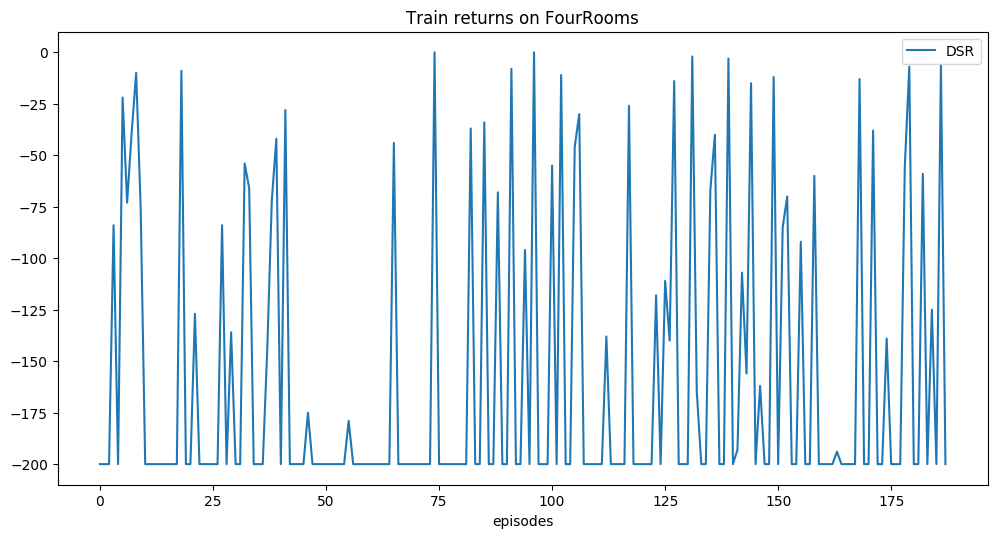

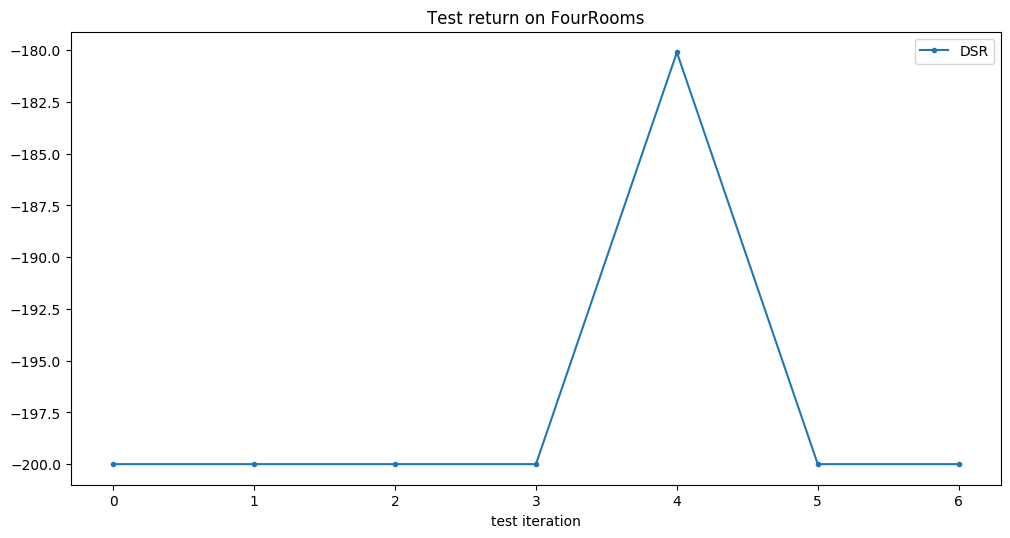

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6), dpi=100)
# plt.plot(train_dqn[:train_max], label='DQN')
plt.plot(train_dsr[:], label='DSR')
plt.title('Train returns on ' + game)
plt.xlabel('episodes'), plt.legend()
plt.show()

plt.figure(figsize=(12,6), dpi=100)
# plt.plot(test_dqn[:test_max], '.-', label='DQN')
plt.plot(test_dsr[:], '.-', label='DSR')
plt.title('Test return on ' + game)
plt.xlabel('test iteration'), plt.legend()
plt.show()